In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel




Fetching data...
Starting experiment on 24129 training samples...
Alpha 0.0 -> Acc: 0.851 | F1: 0.664
Alpha 0.1 -> Acc: 0.850 | F1: 0.662
Alpha 0.2 -> Acc: 0.850 | F1: 0.662
Alpha 0.3 -> Acc: 0.851 | F1: 0.663
Alpha 0.4 -> Acc: 0.850 | F1: 0.663
Alpha 0.5 -> Acc: 0.850 | F1: 0.662
Alpha 0.6 -> Acc: 0.849 | F1: 0.659
Alpha 0.7 -> Acc: 0.848 | F1: 0.658
Alpha 0.8 -> Acc: 0.849 | F1: 0.658
Alpha 0.9 -> Acc: 0.849 | F1: 0.657
Alpha 1.0 -> Acc: 0.847 | F1: 0.650


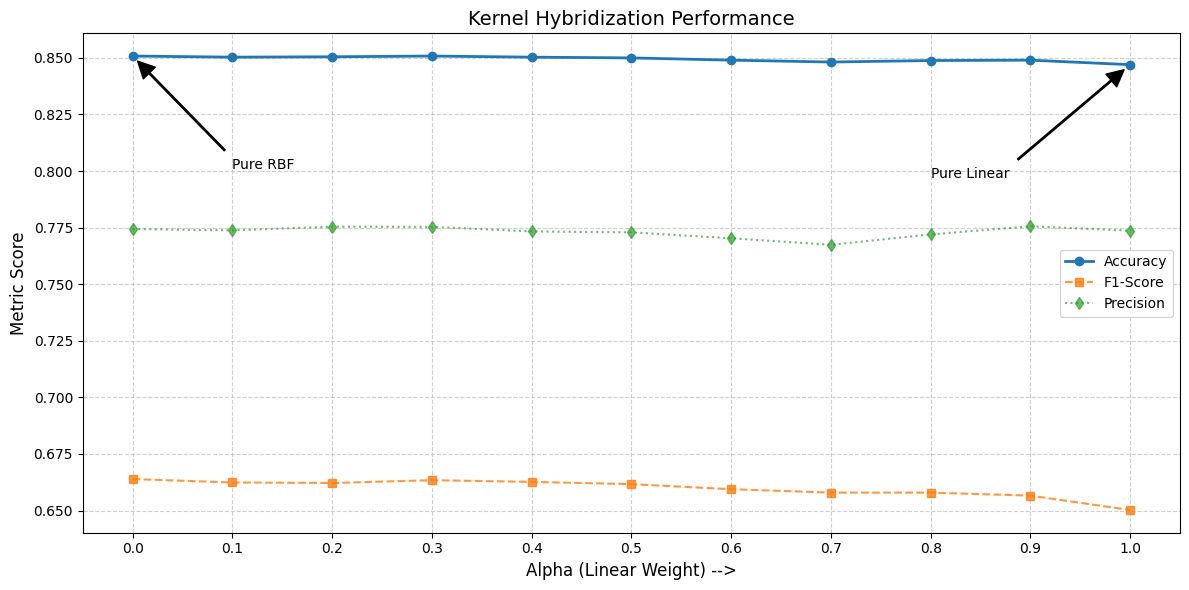

In [5]:
# 1. Load Data
print("Fetching data...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=columns, sep=',\s', engine='python').replace('?', np.nan).dropna()

# 2. Strategic Preprocessing
df['income'] = (df['income'] == '>50K').astype(int)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = [c for c in df.columns if c not in continuous_cols + ['income']]
# LIMIT DATASET SIZE TO FIT 12 GB RAM
# df = df.sample(n=20000, random_state=42)

# Randomly sample to ensure statistical representation
df_final = pd.get_dummies(df, columns=categorical_cols)

X = df_final.drop('income', axis=1)
y = df_final['income'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize only continuous features
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train_raw[continuous_cols])
X_test_cont = scaler.transform(X_test_raw[continuous_cols])

X_train = np.hstack([X_train_cont, X_train_raw.drop(columns=continuous_cols).values]).astype(float)
X_test = np.hstack([X_test_cont, X_test_raw.drop(columns=continuous_cols).values]).astype(float)

# 3. Fixed Normalized Hybrid Kernel Function
def compute_hybrid_kernel(X1, X2, alpha, gamma=0.01, lin_norm_val=None):
    """
    X1: Samples, X2: Training samples
    lin_norm_val: The max absolute value from the TRAINING kernel to prevent data leakage.
    """
    K_lin = linear_kernel(X1, X2)
    
    # Calculate normalization constant from training data if not provided
    if lin_norm_val is None:
        lin_norm_val = np.max(np.abs(K_lin))
        if lin_norm_val == 0: lin_norm_val = 1
        
    K_lin_scaled = K_lin / lin_norm_val
    K_rbf = rbf_kernel(X1, X2, gamma=gamma)
    
    return (alpha * K_lin_scaled + (1 - alpha) * K_rbf), lin_norm_val

# 4. Comparative Experiment
metrics = {'acc': [], 'prec': [], 'rec': [], 'f1': []}
alphas = [0.0, 0.1 ,0.2,0.3, 0.4, 0.5, 0.6, 0.7,  0.8, 0.9, 1.0]

print(f"Starting experiment on {len(X_train)} training samples...")

for a in alphas:
    # 1. Compute Train Kernel and get the normalization constant
    K_train, train_norm = compute_hybrid_kernel(X_train, X_train, a)
    
    # 2. Train Model
    # Using C=1.0 and cache_size for speed
    model = SVC(kernel='precomputed', C=1.0, cache_size=1000)
    model.fit(K_train, y_train)
    
    # 3. Compute Test Kernel using the TRAINING normalization constant
    K_test, _ = compute_hybrid_kernel(X_test, X_train, a, lin_norm_val=train_norm)
    
    # 4. Evaluate
    preds = model.predict(K_test)
    
    metrics['acc'].append(accuracy_score(y_test, preds))
    metrics['prec'].append(precision_score(y_test, preds, zero_division=0))
    metrics['rec'].append(recall_score(y_test, preds))
    metrics['f1'].append(f1_score(y_test, preds))
    
    print(f"Alpha {a:.1f} -> Acc: {metrics['acc'][-1]:.3f} | F1: {metrics['f1'][-1]:.3f}")

# 5. Visualization
plt.figure(figsize=(12, 6))

plt.plot(alphas, metrics['acc'], 'o-', label='Accuracy', linewidth=2)
plt.plot(alphas, metrics['f1'], 's--', label='F1-Score', alpha=0.8)
plt.plot(alphas, metrics['prec'], 'd:', label='Precision', alpha=0.7)

plt.title("Kernel Hybridization Performance", fontsize=14)
plt.xlabel("Alpha (Linear Weight) -->", fontsize=12)
plt.ylabel("Metric Score", fontsize=12)
plt.xticks(alphas)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.annotate('Pure RBF', xy=(0, metrics['acc'][0]), xytext=(0.1, metrics['acc'][0]-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))
plt.annotate('Pure Linear', xy=(1, metrics['acc'][-1]), xytext=(0.8, metrics['acc'][-1]-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

# ----------------------------
# 6) SVM Linearity Check for Adult Dataset
# ----------------------------
def svm_linearity_check(X, y):
    """
    Quick check if data is (almost) linearly separable.
    Uses a very large C in LinearSVC to try to perfectly fit.
    Prints training F1 score and 5-fold CV scores.
    """
    classes = np.unique(y)
    avg = "binary" if len(classes) == 2 else "macro"
    scorer = make_scorer(f1_score, average=avg)

    # Stratified 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Check linear separability on training data
    sep_test = Pipeline([
        ("scaler", StandardScaler()), 
        ("clf", LinearSVC(C=1e6, dual="auto", max_iter=20000, random_state=42))
    ])
    sep_test.fit(X, y)
    preds = sep_test.predict(X)
    f1_train = f1_score(y, preds, average=avg)
    print(f"\nLinear SVM Train F1 (very large C): {f1_train:.4f}")

    # 5-fold CV for robust check
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        clf = LinearSVC(C=1e6, dual="auto", max_iter=20000, random_state=42)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        cv_scores.append(f1_score(y_val, y_pred, average=avg))
    print(f"Linear SVM 5-fold CV F1 scores: {cv_scores}")
    print(f"Mean CV F1: {np.mean(cv_scores):.4f}")

# ----------------------------
# 7) Run linearity check
# ----------------------------
svm_linearity_check(X_train, y_train)



Linear SVM Train F1 (very large C): 0.6600
Linear SVM 5-fold CV F1 scores: [0.6506817113305124, 0.6639269406392694, 0.6635249764373233, 0.6529492455418381, 0.649556696220252]
Mean CV F1: 0.6561
